In [1]:
import numpy as np
import random
import torch
from torch.nn import functional as F
import transformers
import pdb
from datasets import load_dataset, Dataset
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
from transformers import GPT2LMHeadModel
from transformers import GPT2TokenizerFast
from transformers import Trainer
from transformers import TrainingArguments, Seq2SeqTrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

2024-09-09 13:00:10.763110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Finetuning an Encoder-Decoder model (T5) on an autoregressive language modeling task**

In [2]:
def load_init_model_optimizer_tokenizer():
    pretrained_weights = 'google-t5/t5-small'
    model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_weights)
    tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
    # models are usually loaded in eval() mode, so set this to train()
    model.train()
    # initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)
    # using weight decay
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

    return model, optimizer, tokenizer

In [3]:
model, optimizer, tokenizer = load_init_model_optimizer_tokenizer()

/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [4]:
print(model.config)

T5Config {
  "_name_or_path": "google-t5/t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 

In [5]:
train_dataset = load_dataset("huggingartists/taylor-swift", split="train")
train_dataset.info.description

'This dataset is designed to generate lyrics with HuggingArtists.\n'

Let's display an entry of the dataset.

In [6]:
import pandas as pd
from IPython.display import display, HTML

df = pd.DataFrame(train_dataset[:1])

display(HTML(df.to_html()))

,text
0,"Car rides to Malibu\nStrawberry ice cream, one spoon for two\nAnd tradin jackets\nLaughin’ bout how small it looks on you\nWatching reruns of Glee\nBein annoying, singin’ in harmony\nI bet shes braggin to all her friends, sayin youre so unique, hmm\nSo when you gonna tell her that we did that, too?\nShe thinks its special, but its all reused\nThat was our place, I found it first\nI made the jokes you tell to her when shes with you\nDo you get déjà vu when she’s with you?\nDo you get déjà vu? Hmm\nDo you get déjà vu, huh?\nDo you call her, almost say my name?\n’Cause lets be honest, we kinda do sound the same\nAnother actress\nI hate to think that I was just your type\nAnd I bet that she knows Billy Joel\n’Cause you played her Uptown Girl\nYoure singin it together\nNow I bet you even tell her how you love her\nIn between the chorus and the verse \nSo when you gonna tell her that we did that, too?\nShe thinks its special, but it’s all reused\nThat was the show we talked about\nPlayed you the songs shes singing now when shes with you\nDo you get déjà vu when shes with you?\nDo you get déjà vu? \nDo you get déjà vu?\nStrawberry ice cream in Malibu\nDont act like we didnt do that shit, too\nYoure tradin jackets like we used to do\nPlay her piano, but she doesnt know \nThat I was the one who taught you Billy Joel \nA different girl now, but theres nothing new\nI know you get déjà vu\nI know you get déjà vu\nI know you get déjà vu"


In [7]:
encoder_max_length = 512
decoder_max_length = 512

def process_data_to_model_inputs(batch):
    # downsample
    text = batch['text']
    print(len(text))
    text = random.sample(text, 10)

    
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=encoder_max_length)
    output_text = [b[1:] + tokenizer.eos_token for b in text]
    outputs = tokenizer(output_text, padding="max_length", truncation=True, max_length=decoder_max_length)

    batch['input_ids'] = inputs.input_ids
    batch['attention_mask'] = inputs.attention_mask
    batch['decoder_input_ids'] = outputs.input_ids
    batch['decoder_attention_mask'] = outputs.attention_mask
    batch['labels'] = outputs.input_ids.copy()

    # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
    # We have to make sure that the PAD token is ignored
    # batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

    return batch

In [8]:

def get_dataset():
    train_dataset = load_dataset("huggingartists/taylor-swift", split="train")
    return train_dataset

In [9]:
train_dataset = get_dataset()
# batch_size = len(train_dataset)
batch_size = 16

train_dataset = train_dataset.map(
    process_data_to_model_inputs, 
    batched=True,
    batch_size=batch_size,
    remove_columns=['text']
)

In [10]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
    num_rows: 480
})

Let's convert the data to PyTorch Tensors

In [11]:
train_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels']
)

In [12]:
"""
in model.generate you need to set return_dict_in_generate=False
to return torch.LongTensor
"""
def sampling_loop(model, input_ids, attention_mask, num_decode_steps=10):
    output = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=num_decode_steps)

In [13]:
"""
DOING
"""

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:
import warnings;
warnings.filterwarnings('ignore');

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',  
    logging_dir='./logs',
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    warmup_steps=500, # number of warmup steps for learning rate scheduler
    weight_decay=0.01,
    #fp16=True, # not supported on cpu
    logging_steps=2,
    save_steps=10,
    eval_steps=4,
    # logging_steps=1000,
    # save_steps=500,
    # eval_steps=7500,
    # warmup_steps=2000,
    # save_total_limit=3,
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=train_dataset,           # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer
)

In [15]:
trainer.train()

[2024-09-09 13:00:22,222] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to mps (auto detect)


[2024-09-09 13:00:22,766] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


Step,Training Loss,Validation Loss
4,12.729000,14.758242
8,12.264300,14.703562
12,12.222800,14.606404
16,12.858000,14.468764
20,11.768100,14.290671
24,11.839200,14.079820
28,12.071500,13.834391


TrainOutput(global_step=30, training_loss=12.152020899454753, metrics={'train_runtime': 3436.3256, 'train_samples_per_second': 0.14, 'train_steps_per_second': 0.009, 'total_flos': 64964064706560.0, 'train_loss': 12.152020899454753, 'epoch': 1.0})

In [16]:
trainer.evaluate()

{'eval_loss': 13.698516845703125,
 'eval_runtime': 237.317,
 'eval_samples_per_second': 2.023,
 'eval_steps_per_second': 0.126,
 'epoch': 1.0}

In [17]:
trainer.state

TrainerState(epoch=1.0, global_step=30, max_steps=30, logging_steps=2, eval_steps=4, save_steps=10, train_batch_size=16, num_train_epochs=1, num_input_tokens_seen=0, total_flos=64964064706560.0, log_history=[{'loss': 12.6925, 'grad_norm': 52.2101936340332, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.06666666666666667, 'step': 2}, {'loss': 12.729, 'grad_norm': 372.35455322265625, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.13333333333333333, 'step': 4}, {'eval_loss': 14.758241653442383, 'eval_runtime': 218.2005, 'eval_samples_per_second': 2.2, 'eval_steps_per_second': 0.137, 'epoch': 0.13333333333333333, 'step': 4}, {'loss': 12.1748, 'grad_norm': 47.49269104003906, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.2, 'step': 6}, {'loss': 12.2643, 'grad_norm': 41.978885650634766, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.26666666666666666, 'step': 8}, {'eval_loss': 14.703561782836914, 'eval_runtime': 244.9714, 'eval_samples_per_second': 1.959, 'eval_steps_per_se

In [18]:
logs = trainer.state.log_history

In [19]:
import pickle

In [20]:
with open('training_logs_example', 'wb') as handle:
    pickle.dump(logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
import pandas as pd
data = pd.DataFrame(trainer.state.log_history)

In [24]:
data.head(5)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,12.6925,52.210194,2.000000e-07,0.066667,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.7290,372.354553,4.000000e-07,0.133333,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.133333,4,14.758242,218.2005,2.2,0.137,NaN,NaN,NaN,NaN,NaN
3,12.1748,47.492691,6.000000e-07,0.200000,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.2643,41.978886,8.000000e-07,0.266667,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
print(data.keys())

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
train_loss = data['loss'].tolist()

In [32]:
print(col_one_list)

[12.6925, 12.729, nan, 12.1748, 12.2643, nan, 11.871, 12.2228, nan, 12.3258, 12.858, nan, 12.1183, 11.7681, nan, 11.7103, 11.8392, nan, 11.814, 12.0715, nan, 11.8208, nan, nan]


In [36]:
import math
eval_loss = data['eval_loss'].tolist()
idxs = []
for i, e in enumerate(eval_loss):
    if math.isnan(e):
        idxs.append(i)

In [34]:
steps = data['step'].tolist()

In [37]:
steps_filtered = []
eval_loss_filtered = []

In [38]:
for i, s in enumerate(steps):
    if i not in idxs:
        steps_filtered.append(s)

for i, e in enumerate(eval_loss):
    if i not in idxs:
        eval_loss_filtered.append(e)

In [39]:
print(len(steps_filtered))
print(len(eval_loss_filtered))

8
8


Text(0, 0.5, 'eval loss')

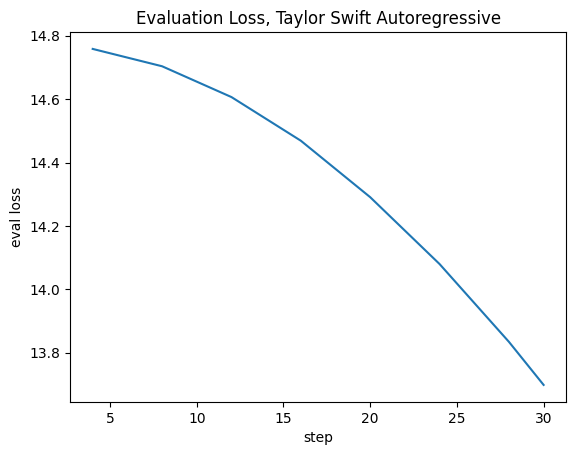

In [44]:
plt.plot(steps_filtered,eval_loss_filtered)
plt.title('Evaluation Loss, Taylor Swift Autoregressive')
plt.xlabel('step')
plt.ylabel('eval loss')

In [ ]:
plt.savefig('taylor_swift_t5_plot.'ng